# Binary Data

Overview of data as it is stored on disk.

## References

Several Wikipedia articles give pretty good overviews of relevant topics:

  - [Byte](https://en.wikipedia.org/wiki/Byte)
  - [UTF-8 encoding](https://en.wikipedia.org/wiki/UTF-8)
  - [Hexidecimal format](https://en.wikipedia.org/wiki/Hexadecimal)
  - [Hex "dumping"](https://en.wikipedia.org/wiki/Hex_dump)

## Binary Data


We have dealt with binary representations when discussing numbers, e.g., $123_{10} = 1111011_{2}$, as verified by

In [1]:
bin(123)

'0b1111011'

The same can, in theory, be done for `float` values, but there is no function as simple as `bin` for doing it.  We can also represent $123_{10} = 7\text{b}_{16}$, or

In [2]:
hex(123)

'0x7b'

Values in the hexadecimal system are written using the 10 decimal digits and the first 6 letters of the (Latin) [alphabet](https://en.wikipedia.org/wiki/Latin_alphabet).  Python uses the `'0x'` prefix to indicate a hexidecimal number (as seen above).  Here are all 16 values:

In [3]:
d = range(0, 16)
b = (bin(i).replace('0b', '') for i in d)
h = (hex(i).replace('0x', '') for i in d)
print((' base-2:' + '{:>4} '*16).format(*b))
print(('base-10:' + '{:>4} '*16).format(*d))
print(('base-16:' + '{:>4} '*16).format(*h))

 base-2:   0    1   10   11  100  101  110  111 1000 1001 1010 1011 1100 1101 1110 1111 
base-10:   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
base-16:   0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 


## From Data to Bytes 

We think of binary as 1's and 0's (correctly so), but data is actually stored as 8-bit bytes because that represents the smallest chunk of data (i.e., [addressable unit]() that can be stored in memory.  

 > Historically, 7 bits were probably enough because $2^7 = 128$ exceeds the roughly 92 characters needed to represents the alphabet (`a-z` and `A-Z`), the numerals `0-9`, and the common punctuation marks (e.g., `,:")]>?`).  So why 8?  It's all about the logic: everything at the hardware level starts off at the binary "1" or "0" level.  It's easier to manage data if it comes as even powers of two, which can't be done with 7 bytes.

In Python, we can convert `int` values to bytes:

In [4]:
a = 123              # try 200 and 300, too.
a.to_bytes(1, 'big') # try 2,3,4  and 'little'

b'{'

That output is probably unexpected. Surely, `{` is not a 1 or 0, and it's not the characters `0-9` and `a-f` that make up hexadecimal representations.  Rather, it is one of the original 128 ASCII characters (or an additional 128 characters) used by Python in its default `str` encoding of a byte.  Here, that default is [UTF-8](https://en.wikipedia.org/wiki/UTF-8), which is a widely used, 8-bit format.  All 256 values that a byte can represent are produced below in the decimal, binary, hexadecimal, and UTF-8 (string) formats (and a selection is shown):

In [5]:
import pandas # nice data handling
fmt = "{:>3}  {:>8}   {:4} {:4}"
b = [bin(d).replace('0b','') for d in range(256)]
h = [hex(d).replace('0x','') for d in range(256)]
s = [str(d.to_bytes(1, 'big'))[1:].replace(r"\x",'').replace("'", '') for d in range(256)]
df = pandas.DataFrame({'base-10': range(256), 'base-2':b, 'base-16':h, 'UTF-8': s})
df[120:130]

,base-10,base-2,base-16,UTF-8
120,120,1111000,78,x
121,121,1111001,79,y
122,122,1111010,7a,z
123,123,1111011,7b,{
124,124,1111100,7c,|
125,125,1111101,7d,}
126,126,1111110,7e,~
127,127,1111111,7f,7f
128,128,10000000,80,80
129,129,10000001,81,81


From the table, we can see that `{` is the UTF-8 equivalent to $123_{10} = 7\text{b}_{16} = 1111011_{2}$.

## Saving Data to Binary Format

We have previously used `f = open(...)` to read or write data to text files.  We can use the same function for writing byte-wise data directly.

In [6]:
f = open('an_integer.b', 'wb')
f.write(a.to_bytes(1, 'big'))
f.close()

Using `ls` shows that the file is, indeed, a single byte:

In [7]:
!ls -l an_integer.b

-rw-r--r--  1 robertsj  staff  1 Oct 19 00:25 an_integer.b


The command line function `xxd` can dump the hexadecimal or binary representation of a file to standard output:

In [8]:
!xxd ./an_integer.b

00000000: 7b                                       {


The `00000000` indicates the byte address (here, just the first one starting at 0) followed by the hexidecimal value stored ($7\text{b}_{16} = 123_{10}$).  The binary representation is

In [9]:
!xxd -b ./an_integer.b

00000000: 01111011                                               {


For more complex data (or more numerous data), the `struct` module and its `pack` and `unpack` functions are useful.  See `help(struct)` and `help(struct.pack)` for details, but, as an example, consider the following:

In [10]:
import struct
struct.pack('iii', 123, 124, 125)

b'{\x00\x00\x00|\x00\x00\x00}\x00\x00\x00'

By inspection, we see can see the strings `{000`, `|000`, and `}000`, the four-byte UTF-8 encodings for 123, 124, and 125, respectively.  We see four bytes because the `int` type in Python (indicated by `i` in the format string `'iii'`) is a standard 4-byte (32-bit) integer.  These bytes are stored in *little* [endian](https://en.wikipedia.org/wiki/Endianness) format, in which the least-significant (smallest) bits are stored first.  That's like storing the number $321_{10}$ as the sequence 1, 2, and 3 in memory.  In *big* endian format (where the least significant bits go last), we have

In [11]:
struct.pack('!iii', 123, 124, 125) # note the ! in the format string

b'\x00\x00\x00{\x00\x00\x00|\x00\x00\x00}'

Now, 123, 124, and 125 are stored as `000{`, `000|`, and `000}`.

Just as data can be packed, so can it be unpacked.  Below, we need to *know* the size of `message` in order to define the format for packing and unpacking, which illustrates a common challenge when designing and using binary formats.  When read and unpacked, the string data must be decoded from the encoded format (utf-8) to the final form (a `str`).

In [12]:
message = "hello"          
data = struct.pack('!id5s', 123, 0.1, bytes(message, 'utf-8'))
f = open('tmp.b', 'wb')
f.write(data)
f.close()

In [13]:
g = open('tmp.b', 'rb')
new_data = struct.unpack('!id5s', g.read())
g.close()
new_data

(123, 0.1, b'hello')

In [14]:
new_data[2].decode('utf-8')

'hello'

## Binary vs. Text



Although data is always binary at some level, we know that we can store a lot in plain text form.  Is there a reason why we'd want to stick with binary?  Consider the following code, which produces an array:

In [15]:
import numpy as np
x = np.linspace(0, 1, 100)

We can save this using `np.savetxt`:

In [16]:
np.savetxt('array.txt', x)
!ls -l array.txt

-rw-r--r--  1 robertsj  staff  2500 Oct 19 00:25 array.txt


The file is 2500 bytes.  Does that make sense?  Remember, a `float` is 8 bytes, and we saved 100 of them to file.  So, we should only need 800 bytes.  However, in a text format, there is significant overhead to represent the original data (e.g., the `.` and `e` are needed for the numerical formatting).  NumPy supports writing directly to binary, too:

In [17]:
np.save('array.npy', x)
!ls -l array.npy

-rw-r--r--  1 robertsj  staff  928 Oct 19 00:25 array.npy


That is better, but there must still be some overhead.  At a minimum, we might expect to need 804 bytes, with the extra 4 containing the size of the array.  An alternative is `pickle`:

In [18]:
import pickle
pickle.dump(x, open('array.p', 'wb'))
!ls -l array.p

-rw-r--r--  1 robertsj  staff  950 Oct 19 00:25 array.p


That's even a bit worse, but `pickle` is neat:

In [19]:
pickle.dump([x, x**2, "hello"], open('blah.p', 'wb'))
data = pickle.load(open('blah.p', 'rb'))
data[-1]

'hello'

The only way to optimize the file size is to pack the data ourselves:

In [20]:
data = struct.pack('i', len(x))
for v in x:
    data += struct.pack('d', v)
f = open('array.b', 'wb')
f.write(data)
f.close()
!ls -l array.b

-rw-r--r--  1 robertsj  staff  804 Oct 19 00:25 array.b


## In Brief: Binary Data in C++

In C++, the process to read and write binary data is not terribly different from the `struct.pack` and `struct.unpack` in Python.  Here's a short C++ program to read the `array.b` produced above (an equivalent Python code follows):

```c++
#include <fstream>
#include <cstdio>
int main()
{
  std::ifstream f("array.b", std::ifstream::binary);
  int n;
  f.read((char*)&n, 4);
  double *x = new double[n];
  for (int i = 0; i < n; ++i)
    f.read((char*)&x[i], 8);
  f.close();
  std::printf("%4i %12.8f %12.8f %12.8f\n", n, x[0], x[50], x[n-1]);
  delete [] x;
  return 0;
}
```

In [21]:
import numpy as np
f = open("array.b", 'rb')
n = struct.unpack('i', f.read(4))[0] # always a tuple even if one value
x = np.zeros(n, dtype='float64')  
for i in range(n):
    x[i] = struct.unpack('d', f.read(8))[0]
f.close()
print('{:4} {:12.8f} {:12.8f} {:12.8f}'.format(n, x[0], x[50], x[-1]))

 100   0.00000000   0.50505051   1.00000000


## Exercises

### 1. Formatting $\pi$ 

Consider $\pi = 3.14159\ldots$ stored as a `float` value named `pi`.  What are the binary, decimal, and hexidecimal representations of the *first* byte of `pi` stored in *big endian* format?  In *little endian* format?

### 2. Why Little Endian?

Why on earth would one choose a little endian format?  

### 3. The Flight Path
Suppose you are programming a UAV for which the flight path is defined by a user-provided sequence of coordinates ($x$, $y$, and $x$) with summary information stored at a UTF-8 string.  The UAV is powered by a simple microcontroller that requires a single binary file be loaded.  This file format is defined as follows:

```
bytes               type              description
-------------------------------------------------------------
0x000000-0x000003:  4-byte int        M = number of characters 
0x000004-0x000008:  4-byte int        N = number of coordinates                                    
0x000009-0x??????:  string (utf-8)    flight path info as M bytes
0x??????-0x??????:  8-byte float      coordinates arranged as
                                      x0,y0,z0,x1,y1,...,zN
-------------------------------------------------------------
```
  All values are little endian.

  Given the following Python variables, create a binary file named `flight_path.b` using this format.

In [88]:
info = """Flight path around MHK starting from Ward Hall 
and ending at beverages using a fixed altitude of 200 ft."""
coords = [(-96.5852293,39.1916258,200.0000000),
          (-96.5627603,39.1911535,200.0000000),
          (-96.5686058,39.1943873,200.0000000),
          (-96.5759980,39.1921672,200.0000000),
          (-96.5714061,39.1793939,200.0000000),
          (-96.5657687,39.1801007,200.0000000)]

### 4. The Flight Log 

Suppose the same UAV logs its *actual* coordinate as a function of time using GPS.  Upon completion of its flight, this data is stored in the file `flight_log.b` which has the format 

```
bytes               type              description
-------------------------------------------------------------
0x000000-0x000003:  4-byte int        N = number of records 
0x??????-0x??????:  8-byte float      N records arranged as
                                      t0,x0,y0,z0,t1,...,zN
-------------------------------------------------------------
```

The following [obfuscated code](https://en.wikipedia.org/wiki/Obfuscation_(software)) produces this file.  Your job is to read it and produce three arrays `t`, `x`, `y`, and `z`.  

In [23]:
import base64
tmp_ = b'.4AbKDero9AdTt9BIJ+:BPh[.AhJ.9FEq=DATVX,G:mJ7.48SK-Qjrf@P2;3CgV9tB5)0o-R`kDE,Qj^+D(s.0JkdJ0JG170JG170JG170JkRB2`YD&@5qaPAM[gQ0Om("1bppEA2n%02J$GX0Jm2u1b^U;0JG170JG170Jk^H0OZhM0J[/r@:V*\'0JkRB2`YA&2_[0J2e+O"0Om("1brJq2`W]P1c&Vq0JkaLAS!PT0JG170JG170Jm2r1H.7(0k3("1LacQ0JkRB2`YA%3A>#QAn<t]0Om("1bq!J3&P/&1LXg+0Jk^K3Fjft0JG170JG480Jk^H2J+m%3+HP\\2.g?,0JkRB2`YG)2Dei!2`3?J0Om("1brT!2)I3MAh[gU0Jk[J1Li*u0JG170JG170JkdJ2*!R+3&kD*@U`h,0JkRB2E>2X0ebFD@5]fJ0Om("1bq\'MA2uG*0judp0JkXIARR8H0JG170JG170JkdJAhuGX1GCgDAi28O0JkRB2`YG\'0K<Z"2`NcN0Om("1bpaF1,`QQ@5foP0JkUH3&rZP0JG170JG170Jk^H0K<N$@PT`"0P4lP0JkRB2`Y;)2`5#%0k4fT0Om("1bq$N3&tM.0f!/l0JkRG1H7\'B0JG170JG170JkaI2.AR(3AG)#1c@4#0JkRB2`YGX0K<QQ1M&7N0Om("1bq\'O@:hN31c@9P0JkOFA2Z,$0JG170JG170JkdJAM@[T@lQ5!0OlnN0JkRB2`Y>Y1,Upu0Out!0Om("1bq("@l@aO@lS\'X0JkLE3&NBD0JG170JG170Jm2r1,(C>0k<!o0Jd2s0JkRB3&rfQ3+=m[@PVFI0Om("1bq%$AS,C31c[<N0JkID1,L[E0JG170JG170Jm2r2.JX+1GWGs2E>8*0JkRB3&rg(3&tG&0f*?!0Om("1bq%$@l@gO0JtXr0Jm?#@5T_m0JG170JG480Jk^H2`3QT2)R*HA78q\'0JkRB3&tJ/@UinZ0P+`M0Om("1bpdq@Q7sZ0K1t\'0Jm9!Ahl%o0JG170JG170JkdJ1c@\'K3AP&%0ekFo0JkRB3&tDW1M($+11`=P0Om("1brW%1HAr)1,_\'N0Jm2t1b^U;0JG170JG170JkdJAS,C/2DR-I@:Ee.0JkRB3&tJY2)o/)@5T`!0Om("1bq$M0fV1%@q.JP0Jk^J3Fjft0JG170JG480JkaI3&"fN1Lap)2e"^T0JkRB3&rs/0f(du2J$JT0Om("1bpsJ2)R0DAS!_S0JkXHARR8H0JG170JG170Jm2r2Dm<I2.87M2.ARV0JkRB3&rm.A7@JT1LjlK0Om("1bpgE3B/rW0f(e#0JkRF1H7\'B0JG170JG170Jm2rARo71@5;D*1h/3p0JkRB3&r[%@lQJZAiMP*0Om("1bpmD0k=^$0OeQN0JkLD3&NBD0JG170JG170Jm5s0f(LD2DdF&1Li4$0JkRB3&riU1GpmI3&b>(0Om("1bppE2`3O&0fCdI0Jm?"@5T_m0JG170JG480Jm2rA2,tr@:;\'*A27[T0JkRB3&tD)@V.S[ARf:+0Om("1bq\'I2E3HOAn*i20Jm2s1b^U;0JG170JG170Jm2r2Do&$A2RmR2)A`P0JkRB3&roV2DJZM2*#/*0Om("1GUe!A2H#N1c])V0JkXGARR8H0JG170JG170JkdJ3A>&(2ISI%A2?)\'0JkRB3&ruW@5MM\'2)I(#0Om("1bq$I@lZ5"3Fk\'X0JkLC3&NBD0JG170JG170JkaI0JI&u1L`*t@:iqV0JkRB3&tD+0k3.RARd_Y0Om("1bpan1H7?L2)I<I0Jm2r1b^U;0JG170JG170Jm5sA27Y,2e?N0@pq>R0JkRB3&rfRA2n$W3&30t0Om("1bq"#2E<^.A7fF40JkLB3&NBD0JG170JG170Jk^H1L`7&3&``PAhdb)0JkRB3&riVARm`11H8r%0Om("2)8Vq2dnR#AN;PT0JkLA3&NBD0JG170JG170JkdJ0JG170JG170JG170JkRB3&roW0f(du3&!$u0Om("2)7!I2)[ES@5)4K0JG170JG170JG170JG170JG170JGLA-QkPpBE'
exec(base64.a85decode(tmp_)[::-1])

For comparison, the following code produces similar (but different values) for `t`, `x`, `y`, and `z`.

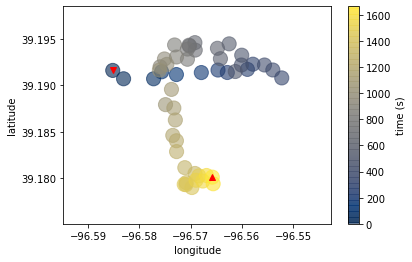

In [89]:
import numpy as np
coords = [(-96.5852293,39.1916258,200.0000000),
          (-96.5530034,39.1913427,200.0000000),
          (-96.5686058,39.1943873,200.0000000),
          (-96.5759980,39.1921672,200.0000000),
          (-96.5714061,39.1793939,200.0000000),
          (-96.5657687,39.1801007,200.0000000)]
t = range(len(coords))
x = [i[0] for i in coords]
y = [i[1] for i in coords]
z = [i[2] for i in coords]
from scipy.interpolate import interp1d 
fx = interp1d(t, x)
fy = interp1d(t, y)
fz = interp1d(t, z)
tt = np.linspace(0, max(t), 50)
np.random.seed(1234)
a=0.1
xx = fx(tt) + np.random.normal(0.0, a*np.std(x), len(tt))
yy = fy(tt) + np.random.normal(0.0, a*np.std(y), len(tt))
zz = fz(tt) + np.random.normal(0.0, 10, len(tt))
xx[0], yy[0], zz[0] = x[0], y[0], z[0]
xx[-1], yy[-1], zz[-1] = x[-1],y[-1],z[-1]
times = tt*333
import matplotlib.pyplot as plt
plt.scatter(xx, yy, c=times, cmap='cividis', s=200, alpha=0.6)
plt.plot(xx[0],yy[0], 'rv')
plt.plot(xx[-1],yy[-1], 'r^')
plt.xlim(min(xx)*1.0001, max(xx)*0.9999)
plt.ylim(min(yy)*0.9999, max(yy)*1.0001)
plt.xlabel('longitude')
plt.ylabel('latitude')
cbar = plt.colorbar()
cbar.set_label('time (s)')

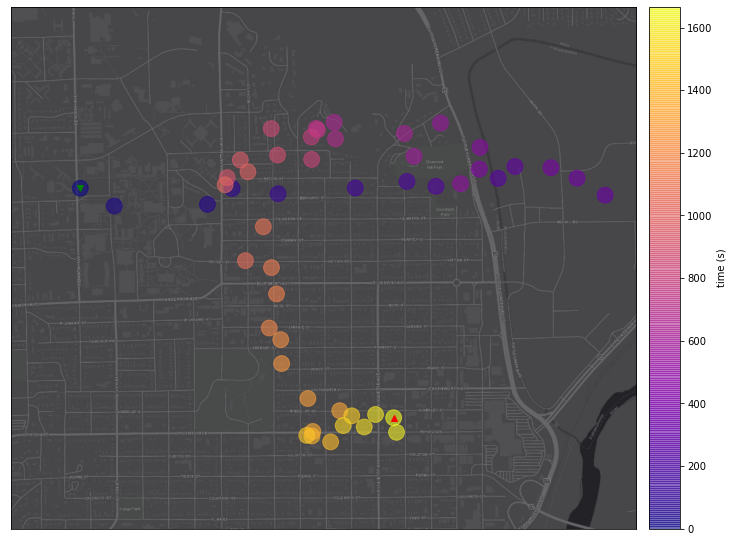

In [112]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

lat = 39.175, 39.200
lon = -96.59, -96.55

plt.figure(figsize=(12, 12))
M = Basemap(projection='cyl', epsg=6923,
            llcrnrlat=lat[0], llcrnrlon=lon[0],
            urcrnrlat=lat[1], urcrnrlon=lon[1], resolution='h')
M.arcgisimage(service='Canvas/World_Dark_Gray_Base', xpixels=1000)
xx_p, yy_p = M(xx, yy)
M.scatter(xx_p, yy_p, c=times, cmap='plasma', s=250, alpha=0.6)
M.plot(xx_p[0], yy_p[0], 'gv')
M.plot(xx_p[-1], yy_p[-1], 'r^')
M.colorbar().set_label('time (s)')